<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250513%5D%20FedAvg-DL%20with%20MLP-LSTM%20model%20on%20WSN-DS%20with%20early%20stopped%20%5B50R%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FedAvg-DL // with clean MLP-LSTM model 5 classes on WSN-DS**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv") #WSN-DS 5 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Class
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,0
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,0
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,0
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,0
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374656,201096,1003,0,201051,6.98337,0,5,1,0,0,1,7,96,0,67,170.14779,3,0.15974,0
374657,201097,1003,0,201037,29.32867,0,5,1,0,0,1,31,39,0,24,82.21043,2,0.06877,0
374658,201098,1003,0,201095,18.51963,0,5,1,0,0,1,17,55,0,31,139.26438,1,0.09437,0
374659,201099,1003,0,201051,8.55001,0,5,1,0,0,1,3,96,0,65,158.27492,3,0.16047,0


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [340066  14596  10049   6638   3312]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [340066 340066 340066 340066 340066]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**The hybrid MLP + LSTM model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed, InputLayer
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the input data for LSTM compatibility
# Assuming the input features need to be reshaped into a 3D array: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the hybrid MLP + LSTM model with regularization
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(InputLayer(input_shape=input_shape))

    # LSTM Layer
    model.add(LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # MLP Layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])  # Adjusted for LSTM input format
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


42509/42509 ━━━━━━━━━━━━━━━━━━━━ 275s 6ms/step - accuracy: 0.8696 - loss: 0.3745 - val_accuracy: 0.9039 - val_loss: 0.2245
Epoch 2/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 272s 6ms/step - accuracy: 0.9045 - loss: 0.2268 - val_accuracy: 0.9020 - val_loss: 0.2313
Epoch 3/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 272s 6ms/step - accuracy: 0.9043 - loss: 0.2193 - val_accuracy: 0.9057 - val_loss: 0.2158
Epoch 4/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 272s 6ms/step - accuracy: 0.9051 - loss: 0.2154 - val_accuracy: 0.9068 - val_loss: 0.2039
Epoch 5/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 274s 6ms/step - accuracy: 0.9050 - loss: 0.2127 - val_accuracy: 0.9073 - val_loss: 0.2012
Epoch 6/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 274s 6ms/step - accuracy: 0.9057 - loss: 0.2107 - val_accuracy: 0.9073 - val_loss: 0.1996
Epoch 7/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 280s 7ms/step - accuracy: 0.9049 - loss: 0.2110 - val_accuracy: 0.9071 - val_loss: 0.1966
Epoch 8/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 276s 6ms/step - accuracy: 0.9

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9642275323
Precision: 0.9658820444
Recall: 0.9642275323
F1-Score: 0.9641839518


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

10628/10628 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step
Accuracy: 0.9642275323
Precision: 0.9658820444
Recall: 0.9642275323
F1-Score: 0.9641839518


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[67756    77     3    56   121]
 [   29 61679  6289    16     0]
 [    0  1285 66728     0     0]
 [ 4285     1     1 63727     0]
 [    2     0     0     0 68011]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.99622131 0.90687075 0.98110655 0.93696886 0.99997059]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-15-c5170017384f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9963094381
Class 1: 0.9970153235
Class 2: 0.9971788410
Class 3: 0.9968017340
Class 4: 0.9998137000

Macro-average AUC: 0.9974238073


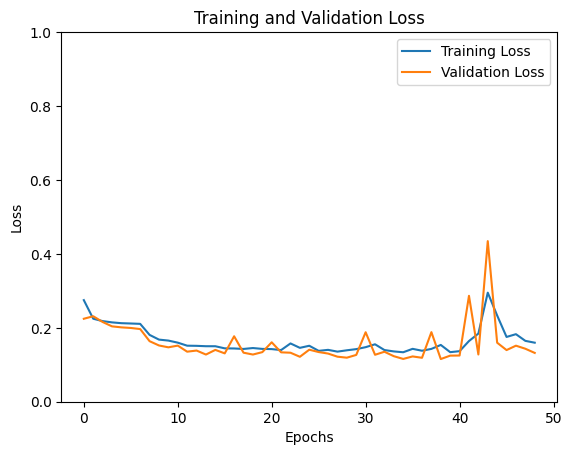

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

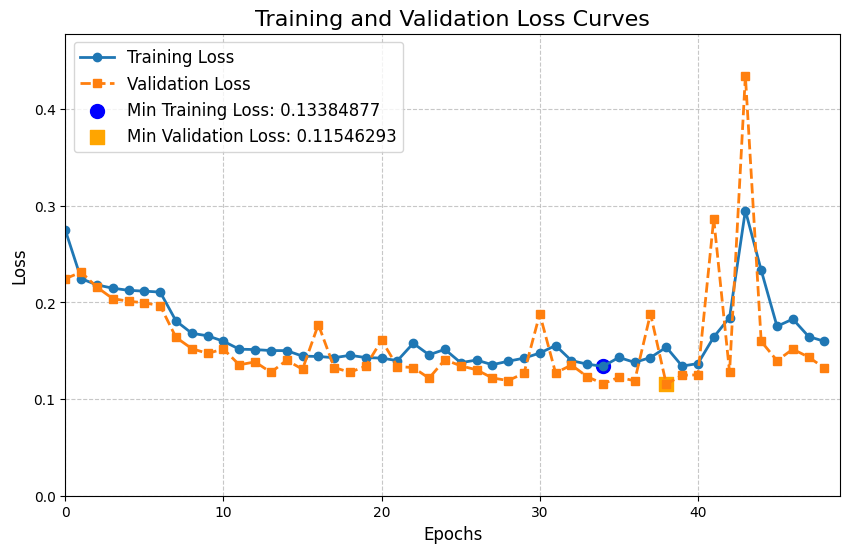

In [ ]:
# prompt: Plot Training and Validation Loss in the way more mathmatically

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... (Your existing code) ...


# Plot Training and Validation Loss with mathematical details
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.plot(history.history['loss'], label='Training Loss', marker='o', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', linestyle='--', linewidth=2)

# Add mathematical details to the plot
min_training_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
min_training_loss_epoch = history.history['loss'].index(min_training_loss)
min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)

plt.scatter(min_training_loss_epoch, min_training_loss, color='blue', marker='o', s=100, label=f'Min Training Loss: {min_training_loss:.8f}')
plt.scatter(min_val_loss_epoch, min_val_loss, color='orange', marker='s', s=100, label=f'Min Validation Loss: {min_val_loss:.8f}')


plt.title('Training and Validation Loss Curves', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.legend(fontsize=12)

plt.xlim(0, len(history.history['loss'])) # Ensure x-axis covers all epochs
plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss']))*1.1) #adjust y axis limit

plt.show()


<ipython-input-18-e1c5c7879700>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


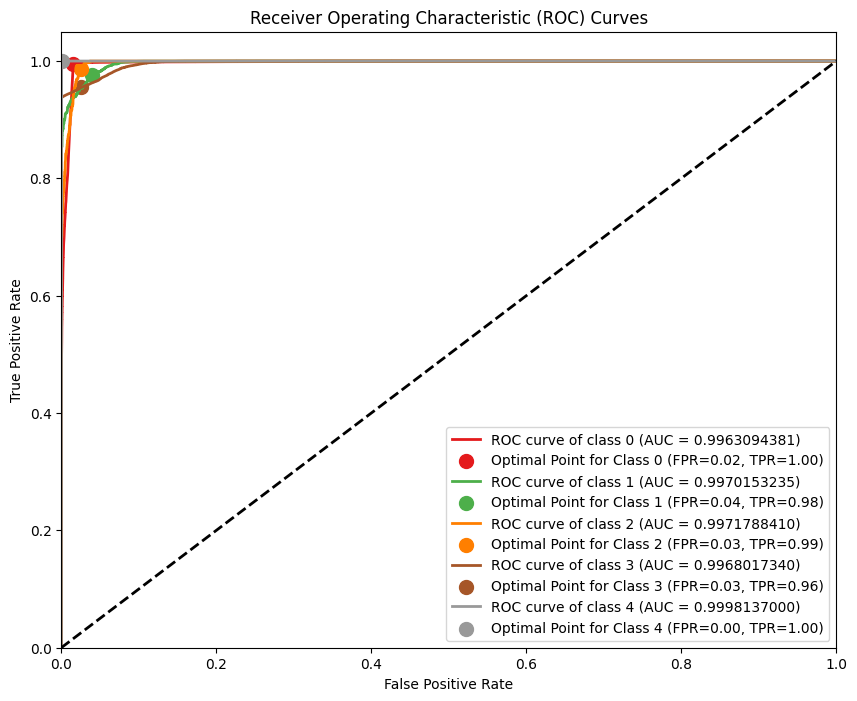


AUC Scores for each class:
Class 0: 0.9963094381
Class 1: 0.9970153235
Class 2: 0.9971788410
Class 3: 0.9968017340
Class 4: 0.9998137000

Macro-average AUC: 0.9974238073


In [ ]:
# prompt: Plot ROC curves and AUC for each class in the way more mathamaticall and show label to point out an important value

from sklearn.metrics import roc_curve, auc

# ... (Your existing code) ...

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.10f})')
    # Find the point closest to (0,1)
    distances = np.sqrt(fpr[i]**2 + (1-tpr[i])**2)
    min_index = np.argmin(distances)
    plt.scatter(fpr[i][min_index], tpr[i][min_index], marker='o', s=100, color=color,
                label=f'Optimal Point for Class {i} (FPR={fpr[i][min_index]:.2f}, TPR={tpr[i][min_index]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show() # Display the plot


# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


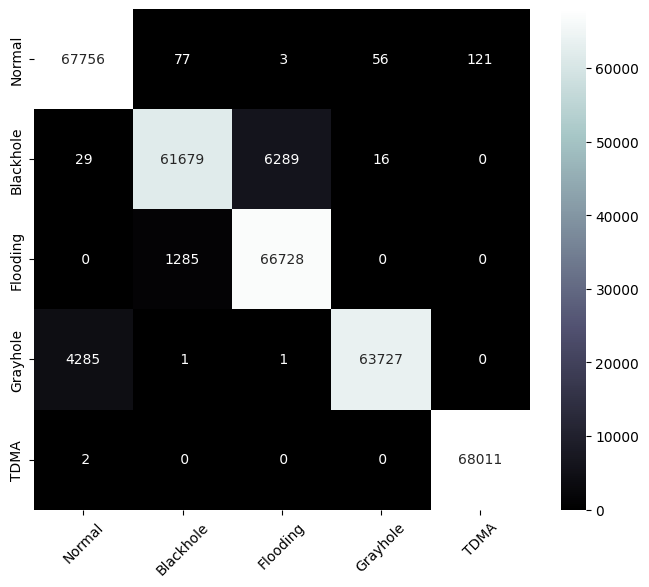

In [ ]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(5), labels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], rotation=45)
plt.yticks(ticks=np.arange(5), labels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], yticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.85)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


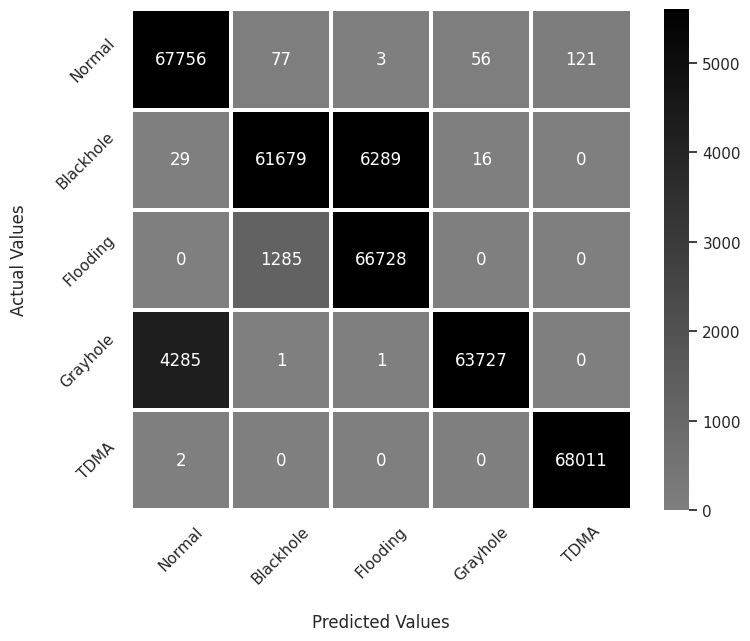

In [ ]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

Confusion Matrix of MLP-LSTM Model


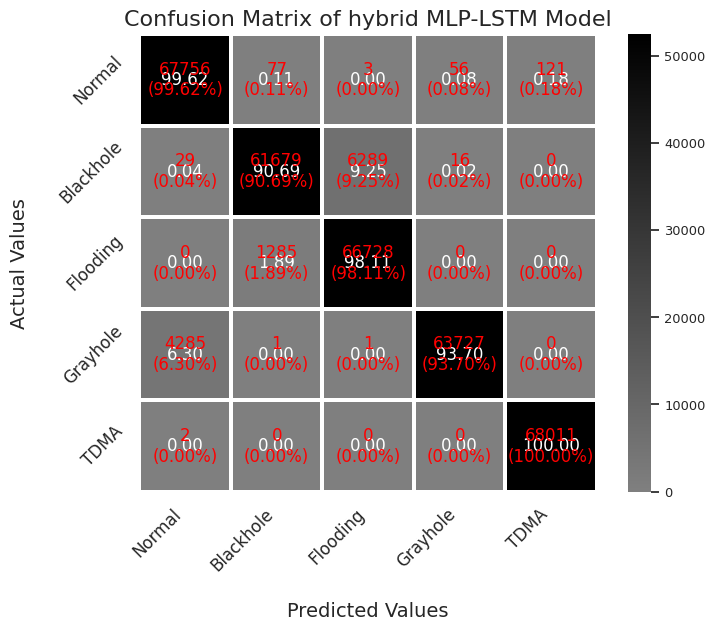

In [ ]:
# prompt: Plot the Confusion Matrix of Federated DL// MLP-LSTM Model in the way more mathmatically

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

def conf_mat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6.5))

    # Annotate with percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    ax = sns.heatmap(cm, annot=cm_percent, fmt=".2f", cmap="gist_yarg",  # Use a suitable colormap
                     vmin=0, vmax=52500, center=0, square=True, linewidths=1.5, annot_kws={"fontsize":12}) # Customize font size
    sns.set(font_scale=1.2) # Adjust font scale for better readability
    ax.set_xlabel('\nPredicted Values', fontsize=14)
    ax.set_ylabel('Actual Values\n', fontsize=14)
    ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'], fontsize=12)
    ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'], fontsize=12)
    plt.xticks(rotation=45, ha='right') # Align x-axis labels
    plt.yticks(rotation=45) # Ensure y-axis labels are horizontal
    plt.title('Confusion Matrix of hybrid MLP-LSTM Model', fontsize=16) # Add title


    # Add text annotations for actual counts within each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}\n({cm_percent[i,j]:.2f}%)',
                     ha='center', va='center', color='red', fontsize=12)  # Customize fontsize for annotations



    plt.tight_layout()
    plt.show()

print("Confusion Matrix of MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

**Federated Learning Simulation (FedAvg)**

In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to measure model performance
def evaluate_global_model(global_model, X_test, y_test):
    y_pred = global_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute performance metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.10f}")
    print(f"Precision: {precision:.10f}")
    print(f"Recall: {recall:.10f}")
    print(f"F1-Score: {f1:.10f}")
    print("\nConfusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1

# Function to analyze communication overhead
def analyze_communication_overhead(local_weights, global_weights):
    communication_cost = 0
    for i in range(len(local_weights)):
        # Compute the size of weights transmitted between clients and server
        communication_cost += sum(w.nbytes for w in local_weights[i])
    communication_cost += sum(w.nbytes for w in global_weights)

    print(f"\nCommunication Overhead: {communication_cost / (1024 ** 2):.8f} MB")  # in megabytes

# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    global_weights = global_model.get_weights()

    communication_overhead = []
    latency_per_round = []

    for round in range(50):  # Simulate 50 communication rounds
        local_weights = []

        start_time = time.time()  # Start measuring latency

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Measure latency
        end_time = time.time()
        latency = end_time - start_time
        latency_per_round.append(latency)

        # Measure communication overhead
        analyze_communication_overhead(local_weights, global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"\nRound {round + 1}: Global Model Accuracy = {acc:.10f}")

        # Evaluate model performance metrics
        evaluate_global_model(global_model, X_test, y_test)

    # Summarize overall latency
    print("\nLatency Analysis:")
    print(f"Average Latency per Round: {np.mean(latency_per_round):.8f} seconds")
    print(f"Total Latency for 10 Rounds: {np.sum(latency_per_round):.8f} seconds")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 1: Global Model Accuracy = 0.6232054830
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.6232054954
Precision: 0.6737116910
Recall: 0.6232054954
F1-Score: 0.6230574666

Confusion Matrix:
[[63079  4454    15   372    93]
 [12291 27293 26226  2203     0]
 [16708  4209 42221  4875     0]
 [15400    73 16316 36225     0]
 [ 4562 19951     0   387 43113]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 2: Global Model Accuracy = 0.9050831199
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9050831309
Precision: 0.9267521385
Recall: 0.9050831309
F1-Score: 0.9018929390

Confusion Matrix:
[[67331   500     1    86    95]
 [    1 41069 26934     9     0]
 [    0     8 67957    48     0]
 [ 4291   243    28 63452     0]
 [   14    20     0     0 67979]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 3: Global Model Accuracy = 0.9061682224
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9061682144
Precision: 0.9285349833
Recall: 0.9061682144
F1-Score: 0.9029362564

Confusion Matrix:
[[67635   235     0    66    77]
 [    6 41055 26932    20     0]
 [    0     0 67954    59     0]
 [ 4302   164    19 63529     0]
 [   24     5     0     0 67984]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 4: Global Model Accuracy = 0.9064916968
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9064916810
Precision: 0.9291128778
Recall: 0.9064916810
F1-Score: 0.9032510440

Confusion Matrix:
[[67727   151     0    59    76]
 [   10 41050 26930    23     0]
 [    0     0 67968    45     0]
 [ 4308   135    31 63540     0]
 [   26     5     0     0 67982]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 5: Global Model Accuracy = 0.9066004753
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9066004834
Precision: 0.9292411124
Recall: 0.9066004834
F1-Score: 0.9033810332

Confusion Matrix:
[[67733   155     0    49    76]
 [    4 41070 26939     0     0]
 [    0     0 67983    30     0]
 [ 4305   147    40 63522     0]
 [   17     0     0     0 67996]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 6: Global Model Accuracy = 0.9066386819
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9066387113
Precision: 0.9294336210
Recall: 0.9066387113
F1-Score: 0.9033917780

Confusion Matrix:
[[67753   129     0    55    76]
 [   31 41041 26932     9     0]
 [    0     0 67973    40     0]
 [ 4334    83    34 63563     0]
 [   22     4     0     0 67987]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 7: Global Model Accuracy = 0.9068445563
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step

Model Performance Metrics:
Accuracy: 0.9068445537
Precision: 0.9296155951
Recall: 0.9068445537
F1-Score: 0.9035858892

Confusion Matrix:
[[67746   135     0    56    76]
 [   14 41038 26930    31     0]
 [    0     0 67974    39     0]
 [ 4303    60    12 63639     0]
 [   19     4     0     0 67990]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 8: Global Model Accuracy = 0.9067563415
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9067563355
Precision: 0.9295185660
Recall: 0.9067563355
F1-Score: 0.9035273052

Confusion Matrix:
[[67753   133     0    51    76]
 [   12 41060 26939     2     0]
 [    0     0 68013     0     0]
 [ 4317   123    45 63529     0]
 [   10     1     0     0 68002]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 9: Global Model Accuracy = 0.9069004059
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9069004252
Precision: 0.9297578391
Recall: 0.9069004252
F1-Score: 0.9036238327

Confusion Matrix:
[[67761   112     0    64    76]
 [   19 41019 26929    46     0]
 [    0     0 67963    50     0]
 [ 4305    35    12 63662     0]
 [   12     0     0     0 68001]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 10: Global Model Accuracy = 0.9068562984
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9068563161
Precision: 0.9298589671
Recall: 0.9068563161
F1-Score: 0.9036044827

Confusion Matrix:
[[67781   112     1    43    76]
 [   38 41034 26939     2     0]
 [    0     0 68013     0     0]
 [ 4380    32    37 63565     0]
 [   15     0     0     0 67998]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 11: Global Model Accuracy = 0.9060094357
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9060094217
Precision: 0.9290032022
Recall: 0.9060094217
F1-Score: 0.9027679407

Confusion Matrix:
[[67789   144     0     4    76]
 [   23 41051 26939     0     0]
 [    0     0 68013     0     0]
 [ 4674    56    34 63250     0]
 [   11     2     0     0 68000]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 12: Global Model Accuracy = 0.9062711596
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9062711356
Precision: 0.9291783721
Recall: 0.9062711356
F1-Score: 0.9030206733

Confusion Matrix:
[[67803   121     0    13    76]
 [   35 41049 26929     0     0]
 [   11    26 67976     0     0]
 [ 4590    48    10 63366     0]
 [   11     4     0     0 67998]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 13: Global Model Accuracy = 0.9062476158
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9062476108
Precision: 0.9292697073
Recall: 0.9062476108
F1-Score: 0.9029917743

Confusion Matrix:
[[67804   129     0     4    76]
 [   37 41046 26930     0     0]
 [    3     2 68008     0     0]
 [ 4646    29    11 63328     0]
 [   14     1     0     0 67998]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 14: Global Model Accuracy = 0.9063887596
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step

Model Performance Metrics:
Accuracy: 0.9063887598
Precision: 0.9294263535
Recall: 0.9063887598
F1-Score: 0.9031323055

Confusion Matrix:
[[67810   111     0    16    76]
 [   40 41043 26930     0     0]
 [    0     2 68011     0     0]
 [ 4593    26    18 63377     0]
 [   13     9     0     0 67991]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 15: Global Model Accuracy = 0.9069092274
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step

Model Performance Metrics:
Accuracy: 0.9069092470
Precision: 0.9297182341
Recall: 0.9069092470
F1-Score: 0.9036640016

Confusion Matrix:
[[67767   120     0    50    76]
 [   26 41057 26930     0     0]
 [    2    24 67987     0     0]
 [ 4355    50     4 63605     0]
 [   16     4     0     0 67993]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 16: Global Model Accuracy = 0.9059858918
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9059858969
Precision: 0.9290107181
Recall: 0.9059858969
F1-Score: 0.9027338515

Confusion Matrix:
[[67815   120     0     2    76]
 [   28 41056 26929     0     0]
 [    0     4 68009     0     0]
 [ 4745    42     8 63219     0]
 [    9     8     0     0 67996]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 17: Global Model Accuracy = 0.9055506587
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9055506872
Precision: 0.9286002563
Recall: 0.9055506872
F1-Score: 0.9022841864

Confusion Matrix:
[[67824   111     1     1    76]
 [   52 41042 26919     0     0]
 [    1    31 67981     0     0]
 [ 4885    29     0 63100     0]
 [   11     2     0     0 68000]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 18: Global Model Accuracy = 0.9061770439
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9061770362
Precision: 0.9290974526
Recall: 0.9061770362
F1-Score: 0.9029325080

Confusion Matrix:
[[67815   119     0     3    76]
 [   25 41071 26917     0     0]
 [    0    20 67993     0     0]
 [ 4675    45     0 63294     0]
 [   14    12     0     0 67987]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 19: Global Model Accuracy = 0.9060829282
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9060829368
Precision: 0.9290791856
Recall: 0.9060829368
F1-Score: 0.9028389370

Confusion Matrix:
[[67807   127     0     3    76]
 [   18 41057 26938     0     0]
 [    0     0 68013     0     0]
 [ 4680    61    19 63254     0]
 [   13     3     0     0 67997]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 20: Global Model Accuracy = 0.9059858918
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9059858969
Precision: 0.9288211301
Recall: 0.9059858969
F1-Score: 0.9027545794

Confusion Matrix:
[[67796   137     1     3    76]
 [    3 41071 26939     0     0]
 [    0     0 68013     0     0]
 [ 4646   129    24 63215     0]
 [    8     5     0     0 68000]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 21: Global Model Accuracy = 0.9058888555
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9058888569
Precision: 0.9287781781
Recall: 0.9058888569
F1-Score: 0.9026542760

Confusion Matrix:
[[67813   122     0     2    76]
 [   18 41084 26911     0     0]
 [    0    47 67966     0     0]
 [ 4770    35     0 63209     0]
 [   11    12     0     0 67990]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 22: Global Model Accuracy = 0.9060800076
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9060799962
Precision: 0.9289360117
Recall: 0.9060799962
F1-Score: 0.9028444692

Confusion Matrix:
[[67802   131     2     2    76]
 [    7 41082 26924     0     0]
 [    0     2 68011     0     0]
 [ 4673   105     3 63233     0]
 [   12     2     0     0 67999]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 23: Global Model Accuracy = 0.9058594704
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9058594508
Precision: 0.9288005046
Recall: 0.9058594508
F1-Score: 0.9026271936

Confusion Matrix:
[[67780   150     6     1    76]
 [   13 41086 26914     0     0]
 [    1    14 67998     0     0]
 [ 4791    34     0 63189     0]
 [    7     7     0     0 67999]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 24: Global Model Accuracy = 0.9060946703
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9060946993
Precision: 0.9288983247
Recall: 0.9060946993
F1-Score: 0.9028520553

Confusion Matrix:
[[67801   128     5     3    76]
 [   10 41062 26941     0     0]
 [    0     3 68010     0     0]
 [ 4619   134     0 63261     0]
 [    7     6     2     0 67998]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 25: Global Model Accuracy = 0.9064769745
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9064769780
Precision: 0.9293428923
Recall: 0.9064769780
F1-Score: 0.9032410296

Confusion Matrix:
[[67808   123     3     3    76]
 [   14 41083 26916     0     0]
 [    0     9 68004     0     0]
 [ 4577    68     0 63369     0]
 [    6     8     1     0 67998]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 26: Global Model Accuracy = 0.9061358571
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step

Model Performance Metrics:
Accuracy: 0.9061358677
Precision: 0.9290379806
Recall: 0.9061358677
F1-Score: 0.9028945175

Confusion Matrix:
[[67815   115     4     3    76]
 [   13 41075 26925     0     0]
 [    0     2 68011     0     0]
 [ 4675    90     0 63249     0]
 [    7    10     0     0 67996]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 27: Global Model Accuracy = 0.9122052789
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step

Model Performance Metrics:
Accuracy: 0.9122052778
Precision: 0.9319720679
Recall: 0.9122052778
F1-Score: 0.9096852743

Confusion Matrix:
[[67774   157     4     2    76]
 [    5 43188 24820     0     0]
 [    0     0 68013     0     0]
 [ 4585   184     8 63237     0]
 [    7     8     0     0 67998]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 28: Global Model Accuracy = 0.9332364798
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step

Model Performance Metrics:
Accuracy: 0.9332364894
Precision: 0.9440600151
Recall: 0.9332364894
F1-Score: 0.9323606959

Confusion Matrix:
[[67754   177     3     3    76]
 [    7 50508 17498     0     0]
 [    0   161 67852     0     0]
 [ 4640   126     0 63248     0]
 [    7     6     0     0 68000]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 29: Global Model Accuracy = 0.9340834022
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step

Model Performance Metrics:
Accuracy: 0.9340833838
Precision: 0.9446535116
Recall: 0.9340833838
F1-Score: 0.9332352540

Confusion Matrix:
[[67775   156     3     3    76]
 [    4 50707 17302     0     0]
 [    0   154 67859     0     0]
 [ 4529   171     3 63311     0]
 [    5    10     0     0 67998]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 30: Global Model Accuracy = 0.9305223227
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step

Model Performance Metrics:
Accuracy: 0.9305223104
Precision: 0.9415680863
Recall: 0.9305223104
F1-Score: 0.9295501889

Confusion Matrix:
[[67496   437     1     3    76]
 [    0 49832 18181     0     0]
 [    0   160 67853     0     0]
 [ 4486   257     1 63270     0]
 [    0    25     0     0 67988]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 31: Global Model Accuracy = 0.9346508980
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step

Model Performance Metrics:
Accuracy: 0.9346509207
Precision: 0.9448692419
Recall: 0.9346509207
F1-Score: 0.9338380924

Confusion Matrix:
[[67706   226     2     3    76]
 [    3 50934 17076     0     0]
 [    0   162 67851     0     0]
 [ 4482   173     0 63359     0]
 [    0    20     0     0 67993]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 32: Global Model Accuracy = 0.9397969842
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9397969806
Precision: 0.9481204281
Recall: 0.9397969806
F1-Score: 0.9392195252

Confusion Matrix:
[[67779   153     4     1    76]
 [    4 52855 15154     0     0]
 [    0   235 67778     0     0]
 [ 4578   245     5 63186     0]
 [    7    11     0     0 67995]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 33: Global Model Accuracy = 0.9394294024
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9394294049
Precision: 0.9472471263
Recall: 0.9394294049
F1-Score: 0.9388856710

Confusion Matrix:
[[67764   168     2     3    76]
 [    4 52975 15034     0     0]
 [    0   584 67429     0     0]
 [ 4533   180     0 63301     0]
 [    5     9     0     0 67999]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 34: Global Model Accuracy = 0.9378944039
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9378944087
Precision: 0.9470152526
Recall: 0.9378944087
F1-Score: 0.9372235846

Confusion Matrix:
[[67744   185     5     3    76]
 [    6 52059 15948     0     0]
 [    0   157 67856     0     0]
 [ 4501   223     0 63290     0]
 [    1    15     0     0 67997]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 35: Global Model Accuracy = 0.9388177395
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9388177589
Precision: 0.9475178553
Recall: 0.9388177589
F1-Score: 0.9381933939

Confusion Matrix:
[[67737   194     3     3    76]
 [    4 52433 15576     0     0]
 [    0   195 67818     0     0]
 [ 4500   234     3 63277     0]
 [    2    16     0     0 67995]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 36: Global Model Accuracy = 0.9351743460
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9351743485
Precision: 0.9455938544
Recall: 0.9351743485
F1-Score: 0.9343565414

Confusion Matrix:
[[67755   177     2     3    76]
 [    2 50989 17022     0     0]
 [    0     1 68012     0     0]
 [ 4511   224    11 63268     0]
 [    2    14     0     0 67997]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 37: Global Model Accuracy = 0.9412320256
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step

Model Performance Metrics:
Accuracy: 0.9412319961
Precision: 0.9487260188
Recall: 0.9412319961
F1-Score: 0.9407304855

Confusion Matrix:
[[67760   171     3     3    76]
 [    4 53498 14511     0     0]
 [    0   424 67589     0     0]
 [ 4540   240     0 63234     0]
 [    4     9     0     0 68000]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 38: Global Model Accuracy = 0.9398146272
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step

Model Performance Metrics:
Accuracy: 0.9398146242
Precision: 0.9481428846
Recall: 0.9398146242
F1-Score: 0.9392224279

Confusion Matrix:
[[67747   185     1     4    76]
 [    4 52731 15278     0     0]
 [    0   223 67790     0     0]
 [ 4405   277     0 63332     0]
 [    2    12     0     0 67999]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 39: Global Model Accuracy = 0.9375180006
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step

Model Performance Metrics:
Accuracy: 0.9375180112
Precision: 0.9469245787
Recall: 0.9375180112
F1-Score: 0.9368284005

Confusion Matrix:
[[67771   152    11     3    76]
 [    3 51865 16145     0     0]
 [    0   156 67857     0     0]
 [ 4517   169     0 63328     0]
 [    2    12     2     0 67997]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 40: Global Model Accuracy = 0.9393470883
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9393470679
Precision: 0.9482026918
Recall: 0.9393470679
F1-Score: 0.9387344619

Confusion Matrix:
[[67752   172    10     3    76]
 [    0 52463 15550     0     0]
 [    0   156 67857     0     0]
 [ 4523   120     0 63371     0]
 [    2     9     5     0 67997]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 41: Global Model Accuracy = 0.9397999048
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step

Model Performance Metrics:
Accuracy: 0.9397999212
Precision: 0.9483389200
Recall: 0.9397999212
F1-Score: 0.9392040322

Confusion Matrix:
[[67768   160     6     3    76]
 [    1 52702 15310     0     0]
 [    0   158 67855     0     0]
 [ 4516   228     0 63270     0]
 [    2    12     0     0 67999]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 42: Global Model Accuracy = 0.9399793148
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step

Model Performance Metrics:
Accuracy: 0.9399792981
Precision: 0.9483924528
Recall: 0.9399792981
F1-Score: 0.9393593884

Confusion Matrix:
[[67696   235     3     3    76]
 [    3 52663 15347     0     0]
 [    0     1 68012     0     0]
 [ 4255   476     0 63283     0]
 [    0    12     0     0 68001]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 43: Global Model Accuracy = 0.9409555793
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step

Model Performance Metrics:
Accuracy: 0.9409555792
Precision: 0.9490432791
Recall: 0.9409555792
F1-Score: 0.9404045851

Confusion Matrix:
[[67711   220     1     5    76]
 [    2 53101 14910     0     0]
 [    0   158 67855     0     0]
 [ 4457   235     4 63318     0]
 [    0    10     1     0 68002]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 44: Global Model Accuracy = 0.9416524768
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step

Model Performance Metrics:
Accuracy: 0.9416525027
Precision: 0.9497834700
Recall: 0.9416525027
F1-Score: 0.9411078925

Confusion Matrix:
[[67672   213     5    47    76]
 [    3 53058 14952     0     0]
 [    0   157 67856     0     0]
 [ 4245   127     1 63641     0]
 [    0    12     4     0 67997]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 45: Global Model Accuracy = 0.9356389642
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step

Model Performance Metrics:
Accuracy: 0.9356389642
Precision: 0.9454833119
Recall: 0.9356389642
F1-Score: 0.9348384727

Confusion Matrix:
[[67702   228     4     3    76]
 [    0 51194 16819     0     0]
 [    0     1 68012     0     0]
 [ 4261   484     0 63269     0]
 [    0     7     4     0 68002]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 46: Global Model Accuracy = 0.9449283481
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step

Model Performance Metrics:
Accuracy: 0.9449283374
Precision: 0.9497347500
Recall: 0.9449283374
F1-Score: 0.9446343247

Confusion Matrix:
[[67693   240     1     3    76]
 [    0 55598 12415     0     0]
 [    0  1254 66759     0     0]
 [ 4294   430     0 63290     0]
 [    1    14     0     0 67998]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 47: Global Model Accuracy = 0.9373885989
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step

Model Performance Metrics:
Accuracy: 0.9373886246
Precision: 0.9464643487
Recall: 0.9373886246
F1-Score: 0.9367178127

Confusion Matrix:
[[67435   498     2     2    76]
 [    0 52010 16003     0     0]
 [    0     1 68012     0     0]
 [ 4495   179     0 63340     0]
 [    0    36     0     0 67977]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 48: Global Model Accuracy = 0.9398734570
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step

Model Performance Metrics:
Accuracy: 0.9398734363
Precision: 0.9487679255
Recall: 0.9398734363
F1-Score: 0.9392522212

Confusion Matrix:
[[67774   157     3     3    76]
 [    1 52539 15473     0     0]
 [    0     2 68011     0     0]
 [ 4499   216     4 63295     0]
 [    1    12     0     0 68000]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 49: Global Model Accuracy = 0.9459457994
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step

Model Performance Metrics:
Accuracy: 0.9459457870
Precision: 0.9519696967
Recall: 0.9459457870
F1-Score: 0.9455946153

Confusion Matrix:
[[67764   168     2     3    76]
 [    3 55145 12865     0     0]
 [    0   522 67491     0     0]
 [ 4512   217     3 63282     0]
 [    1    10     0     0 68002]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77355194 MB

Round 50: Global Model Accuracy = 0.9375915527
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step

Model Performance Metrics:
Accuracy: 0.9375915264
Precision: 0.9468351289
Recall: 0.9375915264
F1-Score: 0.9368880266

Confusion Matrix:
[[67691   238     5     3    76]
 [    2 51867 16144     0     0]
 [    0     1 68012     0     0]
 [ 4264   439    40 63271     0]
 [    0    11     0     0 68002]]

Latency Analysis:
Average Latency per Round: 424.82197999 seconds
Total Latency for 10 Rounds: 21241.09899926 seconds
